In [1]:
# credit_fraud_pipeline.py
# Requirements: pandas, numpy, scikit-learn, imbalanced-learn, xgboost, matplotlib, seaborn (optional)
# pip install pandas numpy scikit-learn imbalanced-learn xgboost matplotlib seaborn

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_recall_curve, average_precision_score,
                             roc_auc_score, precision_score, recall_score, f1_score)
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import joblib

# -------------- Config --------------
DATA_PATH = "creditcard.csv"   # change if needed
RANDOM_STATE = 42
TEST_SIZE = 0.2

# -------------- Load data --------------
df = pd.read_csv(DATA_PATH)
print("Loaded:", df.shape)
print(df.columns.tolist())

# Typical Kaggle file has 'Time', 'V1'..'V28', 'Amount', 'Class' where Class=1 is fraud
TARGET = "Class"

# -------------- Basic exploration --------------
print("Class distribution:")
print(df[TARGET].value_counts(normalize=True).rename("ratio"))

# -------------- Feature engineering --------------
# If dataset already has PCA features (V1..V28) keep them. We'll standardize Amount and Time if useful.
features = [c for c in df.columns if c != TARGET]

# Optionally drop Time (if not helpful)
# features.remove('Time')

X = df[features].copy()
y = df[TARGET].copy()

# -------------- Train-test split (stratified) --------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, "Test:", X_test.shape)

# -------------- Pipeline + resampling (SMOTE) + model --------------
# We'll scale 'Amount' (and Time if kept) — other V* columns typically already scaled (if using Kaggle data)
numeric_cols = [col for col in X_train.columns if col.lower() in ("amount", "time")]
other_cols = [c for c in X_train.columns if c not in numeric_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        # other columns pass-through
    ],
    remainder="passthrough",
)

# Example 1: XGBoost with class_weight via scale_pos_weight
# compute scale_pos_weight
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1
)


Loaded: (284807, 31)
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Class distribution:
Class
0    0.998273
1    0.001727
Name: ratio, dtype: float64
Train: (227845, 30) Test: (56962, 30)
scale_pos_weight: 577.2868020304569


In [2]:

# Build pipeline WITHOUT SMOTE: (we rely on scale_pos_weight)
pipe_xgb = Pipeline([
    ("pre", preprocessor),
    ("model", xgb),
])

# Optionally build a pipeline WITH SMOTE + RandomForest
smote = SMOTE(random_state=RANDOM_STATE)

Cross-validating XGBoost (no resample, class-weighting)...


/home/suyashmishra/miniconda3/envs/project/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [09:38:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/suyashmishra/miniconda3/envs/project/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [09:38:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/suyashmishra/miniconda3/envs/project/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [09:38:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/suyashmishra/miniconda3/envs/project/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [09:38:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

Average precision (CV): 0.8415457583142232
ROC AUC (CV): 0.979608599583015
Fitting final XGBoost on full training set...


/home/suyashmishra/miniconda3/envs/project/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [09:38:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting RF+SMOTE (alternative)...
=== XGBoost (scale_pos_weight) ===
AP (AUC-PR): 0.8657
ROC AUC: 0.9778
Precision@0.5: 0.8367
Recall@0.5: 0.8367
F1@0.5: 0.8367
Confusion matrix (rows: true, cols: pred):
 [[56848    16]
 [   16    82]]
=== RF + SMOTE ===
AP (AUC-PR): 0.8739
ROC AUC: 0.9729
Precision@0.5: 0.8421
Recall@0.5: 0.8163
F1@0.5: 0.829
Confusion matrix (rows: true, cols: pred):
 [[56849    15]
 [   18    80]]
Threshold for recall>=0.6: 0.99956137
Precision: 1.0
Recall: 0.6020408163265306
F1: 0.7515923566878981


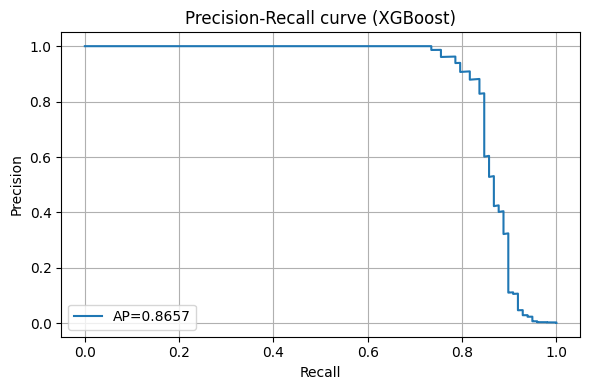

IsolationForest AP: 0.1557546627981043
IsolationForest ROC: 0.9560306079381669
Combined AP: 0.7997525316977935
Combined ROC: 0.9676582436576207
Saved model to models
Example prob: 3.6228823e-05 pred: 0
Loaded: (284807, 31)
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Class distribution:
Class
0    0.998273
1    0.001727
Name: ratio, dtype: float64
Train: (227845, 30) Test: (56962, 30)
scale_pos_weight: 577.2868020304569


In [3]:

rf = RandomForestClassifier(n_estimators=200,n_jobs=-1, class_weight="balanced", random_state=RANDOM_STATE)

pipe_rf_smote = ImbPipeline([
    ("pre", preprocessor),
    ("smote", smote),
    ("model", rf),
])

# -------------- Cross-validated predictions for calibration & early evaluation --------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("Cross-validating XGBoost (no resample, class-weighting)...")
from sklearn.model_selection import cross_val_predict
y_scores_cv = cross_val_predict(pipe_xgb, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1)[:,1]
print("Average precision (CV):", average_precision_score(y_train, y_scores_cv))
print("ROC AUC (CV):", roc_auc_score(y_train, y_scores_cv))

# -------------- Fit final models --------------
print("Fitting final XGBoost on full training set...")
pipe_xgb.fit(X_train, y_train)

print("Fitting RF+SMOTE (alternative)...")
pipe_rf_smote.fit(X_train, y_train)

# -------------- Evaluate on test set --------------
def eval_model(pipe, X_test, y_test, label="model"):
    probs = pipe.predict_proba(X_test)[:,1]
    preds_default = (probs >= 0.5).astype(int)
    ap = average_precision_score(y_test, probs)
    roc = roc_auc_score(y_test, probs)
    prec = precision_score(y_test, preds_default, zero_division=0)
    rec = recall_score(y_test, preds_default)
    f1 = f1_score(y_test, preds_default)
    print(f"=== {label} ===")
    print("AP (AUC-PR):", round(ap,4))
    print("ROC AUC:", round(roc,4))
    print("Precision@0.5:", round(prec,4))
    print("Recall@0.5:", round(rec,4))
    print("F1@0.5:", round(f1,4))
    # confusion matrix
    cm = confusion_matrix(y_test, preds_default)
    print("Confusion matrix (rows: true, cols: pred):\n", cm)
    return probs

probs_xgb = eval_model(pipe_xgb, X_test, y_test, "XGBoost (scale_pos_weight)")
probs_rf = eval_model(pipe_rf_smote, X_test, y_test, "RF + SMOTE")

# -------------- Threshold tuning using precision-recall curve (choose threshold for desired recall/precision) --------------
precision, recall, thresholds = precision_recall_curve(y_test, probs_xgb)
ap = average_precision_score(y_test, probs_xgb)

def choose_threshold_for_recall(target_recall=0.8):
    # find smallest threshold where recall >= target_recall
    idx = np.where(recall >= target_recall)[0]
    if idx.size == 0:
        return None
    chosen = thresholds[idx[-1]] if idx[-1] < len(thresholds) else thresholds[-1]
    return chosen

# Example: choose threshold to achieve ~0.6 recall
t = choose_threshold_for_recall(0.6)
print("Threshold for recall>=0.6:", t)
if t is not None:
    preds_t = (probs_xgb >= t).astype(int)
    print("Precision:", precision_score(y_test, preds_t))
    print("Recall:", recall_score(y_test, preds_t))
    print("F1:", f1_score(y_test, preds_t))

# Plot PR curve
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"AP={ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve (XGBoost)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------- Anomaly detection (IsolationForest) as secondary detector --------------
iso = IsolationForest(n_estimators=200, contamination=float(y.mean()), random_state=RANDOM_STATE, n_jobs=-1)
# fit on training set using preprocessed features (deterministic)
X_train_prep = preprocessor.fit_transform(X_train)
iso.fit(X_train_prep)
X_test_prep = preprocessor.transform(X_test)
iso_scores = -iso.decision_function(X_test_prep)  # higher -> more anomalous
# Evaluate anomaly detector
print("IsolationForest AP:", average_precision_score(y_test, iso_scores))
print("IsolationForest ROC:", roc_auc_score(y_test, iso_scores))

# -------------- Combine scores (example: average normalized scores) --------------
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
combined = scaler.fit_transform(np.vstack([probs_xgb, iso_scores]).T).mean(axis=1)
print("Combined AP:", average_precision_score(y_test, combined))
print("Combined ROC:", roc_auc_score(y_test, combined))

# -------------- Persist best model (choose XGBoost pipeline) --------------
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)
joblib.dump(pipe_xgb, os.path.join(MODEL_DIR, "pipe_xgb.joblib"))
joblib.dump(preprocessor, os.path.join(MODEL_DIR, "preprocessor.joblib"))
print("Saved model to", MODEL_DIR)

# -------------- Quick inference example --------------
def predict_transaction(pipe, row: pd.Series, threshold=0.5):
    prob = pipe.predict_proba(row.to_frame().T)[:,1][0]
    return prob, int(prob >= threshold)

example_row = X_test.iloc[0]
prob, pred = predict_transaction(pipe_xgb, example_row, threshold=0.5)
print("Example prob:", prob, "pred:", pred)

# Done
# credit_fraud_pipeline.py
# Requirements: pandas, numpy, scikit-learn, imbalanced-learn, xgboost, matplotlib, seaborn (optional)
# pip install pandas numpy scikit-learn imbalanced-learn xgboost matplotlib seaborn

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_recall_curve, average_precision_score,
                             roc_auc_score, precision_score, recall_score, f1_score)
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import joblib

# -------------- Config --------------
DATA_PATH = "creditcard.csv"   # change if needed
RANDOM_STATE = 42
TEST_SIZE = 0.2

# -------------- Load data --------------
df = pd.read_csv(DATA_PATH)
print("Loaded:", df.shape)
print(df.columns.tolist())

# Typical Kaggle file has 'Time', 'V1'..'V28', 'Amount', 'Class' where Class=1 is fraud
TARGET = "Class"

# -------------- Basic exploration --------------
print("Class distribution:")
print(df[TARGET].value_counts(normalize=True).rename("ratio"))

# -------------- Feature engineering --------------
# If dataset already has PCA features (V1..V28) keep them. We'll standardize Amount and Time if useful.
features = [c for c in df.columns if c != TARGET]

# Optionally drop Time (if not helpful)
# features.remove('Time')

X = df[features].copy()
y = df[TARGET].copy()

# -------------- Train-test split (stratified) --------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, "Test:", X_test.shape)

# -------------- Pipeline + resampling (SMOTE) + model --------------
# We'll scale 'Amount' (and Time if kept) — other V* columns typically already scaled (if using Kaggle data)
numeric_cols = [col for col in X_train.columns if col.lower() in ("amount", "time")]
other_cols = [c for c in X_train.columns if c not in numeric_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        # other columns pass-through
    ],
    remainder="passthrough",
)

# Example 1: XGBoost with class_weight via scale_pos_weight
# compute scale_pos_weight
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Build pipeline WITHOUT SMOTE: (we rely on scale_pos_weight)
pipe_xgb = Pipeline([
    ("pre", preprocessor),
    ("model", xgb),
])

Cross-validating XGBoost (no resample, class-weighting)...


/home/suyashmishra/miniconda3/envs/project/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [09:41:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/suyashmishra/miniconda3/envs/project/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [09:41:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/suyashmishra/miniconda3/envs/project/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [09:41:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/suyashmishra/miniconda3/envs/project/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [09:41:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

Average precision (CV): 0.8415457583142232
ROC AUC (CV): 0.979608599583015
Fitting final XGBoost on full training set...


/home/suyashmishra/miniconda3/envs/project/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [09:41:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting RF+SMOTE (alternative)...
=== XGBoost (scale_pos_weight) ===
AP (AUC-PR): 0.8657
ROC AUC: 0.9778
Precision@0.5: 0.8367
Recall@0.5: 0.8367
F1@0.5: 0.8367
Confusion matrix (rows: true, cols: pred):
 [[56848    16]
 [   16    82]]
=== RF + SMOTE ===
AP (AUC-PR): 0.8739
ROC AUC: 0.9729
Precision@0.5: 0.8421
Recall@0.5: 0.8163
F1@0.5: 0.829
Confusion matrix (rows: true, cols: pred):
 [[56849    15]
 [   18    80]]
Threshold for recall>=0.6: 0.99956137
Precision: 1.0
Recall: 0.6020408163265306
F1: 0.7515923566878981


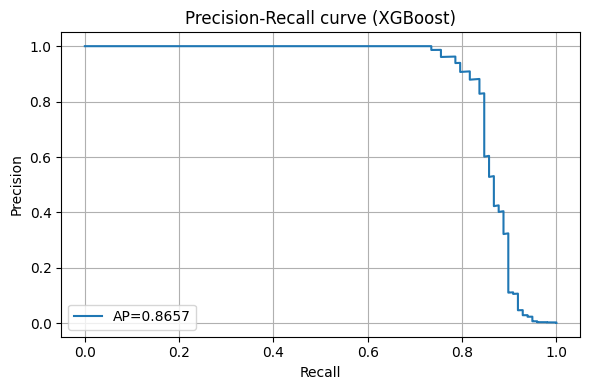

In [4]:


# Optionally build a pipeline WITH SMOTE + RandomForest
smote = SMOTE(random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE)

pipe_rf_smote = ImbPipeline([
    ("pre", preprocessor),
    ("smote", smote),
    ("model", rf),
])

# -------------- Cross-validated predictions for calibration & early evaluation --------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("Cross-validating XGBoost (no resample, class-weighting)...")
from sklearn.model_selection import cross_val_predict
y_scores_cv = cross_val_predict(pipe_xgb, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1)[:,1]
print("Average precision (CV):", average_precision_score(y_train, y_scores_cv))
print("ROC AUC (CV):", roc_auc_score(y_train, y_scores_cv))

# -------------- Fit final models --------------
print("Fitting final XGBoost on full training set...")
pipe_xgb.fit(X_train, y_train)

print("Fitting RF+SMOTE (alternative)...")
pipe_rf_smote.fit(X_train, y_train)

# -------------- Evaluate on test set --------------
def eval_model(pipe, X_test, y_test, label="model"):
    probs = pipe.predict_proba(X_test)[:,1]
    preds_default = (probs >= 0.5).astype(int)
    ap = average_precision_score(y_test, probs)
    roc = roc_auc_score(y_test, probs)
    prec = precision_score(y_test, preds_default, zero_division=0)
    rec = recall_score(y_test, preds_default)
    f1 = f1_score(y_test, preds_default)
    print(f"=== {label} ===")
    print("AP (AUC-PR):", round(ap,4))
    print("ROC AUC:", round(roc,4))
    print("Precision@0.5:", round(prec,4))
    print("Recall@0.5:", round(rec,4))
    print("F1@0.5:", round(f1,4))
    # confusion matrix
    cm = confusion_matrix(y_test, preds_default)
    print("Confusion matrix (rows: true, cols: pred):\n", cm)
    return probs

probs_xgb = eval_model(pipe_xgb, X_test, y_test, "XGBoost (scale_pos_weight)")
probs_rf = eval_model(pipe_rf_smote, X_test, y_test, "RF + SMOTE")

# -------------- Threshold tuning using precision-recall curve (choose threshold for desired recall/precision) --------------
precision, recall, thresholds = precision_recall_curve(y_test, probs_xgb)
ap = average_precision_score(y_test, probs_xgb)

def choose_threshold_for_recall(target_recall=0.8):
    # find smallest threshold where recall >= target_recall
    idx = np.where(recall >= target_recall)[0]
    if idx.size == 0:
        return None
    chosen = thresholds[idx[-1]] if idx[-1] < len(thresholds) else thresholds[-1]
    return chosen

# Example: choose threshold to achieve ~0.6 recall
t = choose_threshold_for_recall(0.6)
print("Threshold for recall>=0.6:", t)
if t is not None:
    preds_t = (probs_xgb >= t).astype(int)
    print("Precision:", precision_score(y_test, preds_t))
    print("Recall:", recall_score(y_test, preds_t))
    print("F1:", f1_score(y_test, preds_t))

# Plot PR curve
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"AP={ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve (XGBoost)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:

# -------------- Anomaly detection (IsolationForest) as secondary detector --------------
iso = IsolationForest(n_estimators=200, contamination=float(y.mean()), random_state=RANDOM_STATE)
# fit on training set using preprocessed features (deterministic)
X_train_prep = preprocessor.fit_transform(X_train)
iso.fit(X_train_prep)
X_test_prep = preprocessor.transform(X_test)
iso_scores = -iso.decision_function(X_test_prep)  # higher -> more anomalous
# Evaluate anomaly detector
print("IsolationForest AP:", average_precision_score(y_test, iso_scores))
print("IsolationForest ROC:", roc_auc_score(y_test, iso_scores))

# -------------- Combine scores (example: average normalized scores) --------------
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
combined = scaler.fit_transform(np.vstack([probs_xgb, iso_scores]).T).mean(axis=1)
print("Combined AP:", average_precision_score(y_test, combined))
print("Combined ROC:", roc_auc_score(y_test, combined))

# -------------- Persist best model (choose XGBoost pipeline) --------------
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)
joblib.dump(pipe_xgb, os.path.join(MODEL_DIR, "pipe_xgb.joblib"))
joblib.dump(preprocessor, os.path.join(MODEL_DIR, "preprocessor.joblib"))
print("Saved model to", MODEL_DIR)

# -------------- Quick inference example --------------
def predict_transaction(pipe, row: pd.Series, threshold=0.5):
    prob = pipe.predict_proba(row.to_frame().T)[:,1][0]
    return prob, int(prob >= threshold)

example_row = X_test.iloc[0]
prob, pred = predict_transaction(pipe_xgb, example_row, threshold=0.5)
print("Example prob:", prob, "pred:", pred)

# Done


IsolationForest AP: 0.1557546627981043
IsolationForest ROC: 0.9560306079381669
Combined AP: 0.7997525316977935
Combined ROC: 0.9676582436576207
Saved model to models
Example prob: 3.6228823e-05 pred: 0


/tmp/ipykernel_29370/1844684746.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Class", data=df, palette="Set2")


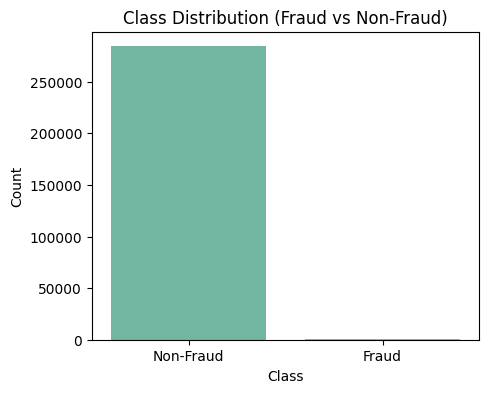

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.countplot(x="Class", data=df, palette="Set2")
plt.title("Class Distribution (Fraud vs Non-Fraud)")
plt.xticks([0,1], ["Non-Fraud", "Fraud"])
plt.ylabel("Count")
plt.show()


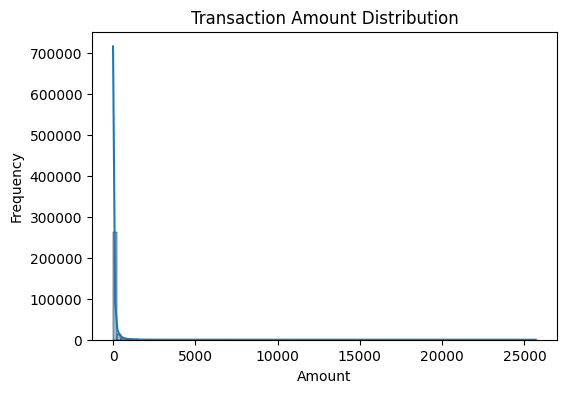

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(df["Amount"], bins=100, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()


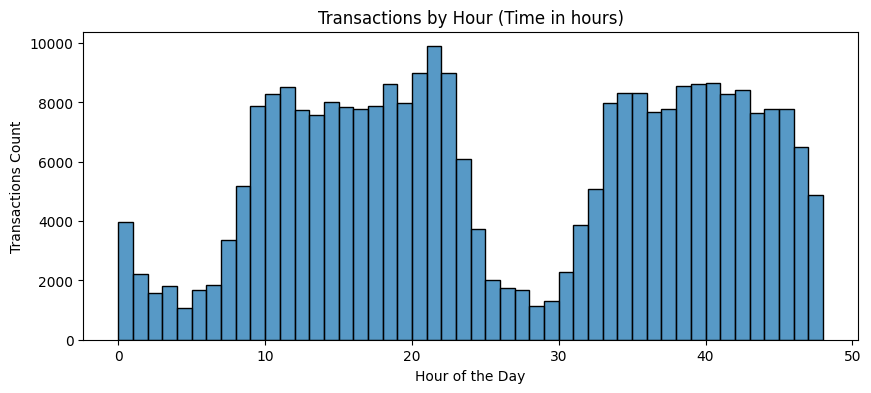

In [8]:
plt.figure(figsize=(10,4))
sns.histplot(df["Time"]/3600, bins=48, kde=False)
plt.title("Transactions by Hour (Time in hours)")
plt.xlabel("Hour of the Day")
plt.ylabel("Transactions Count")
plt.show()


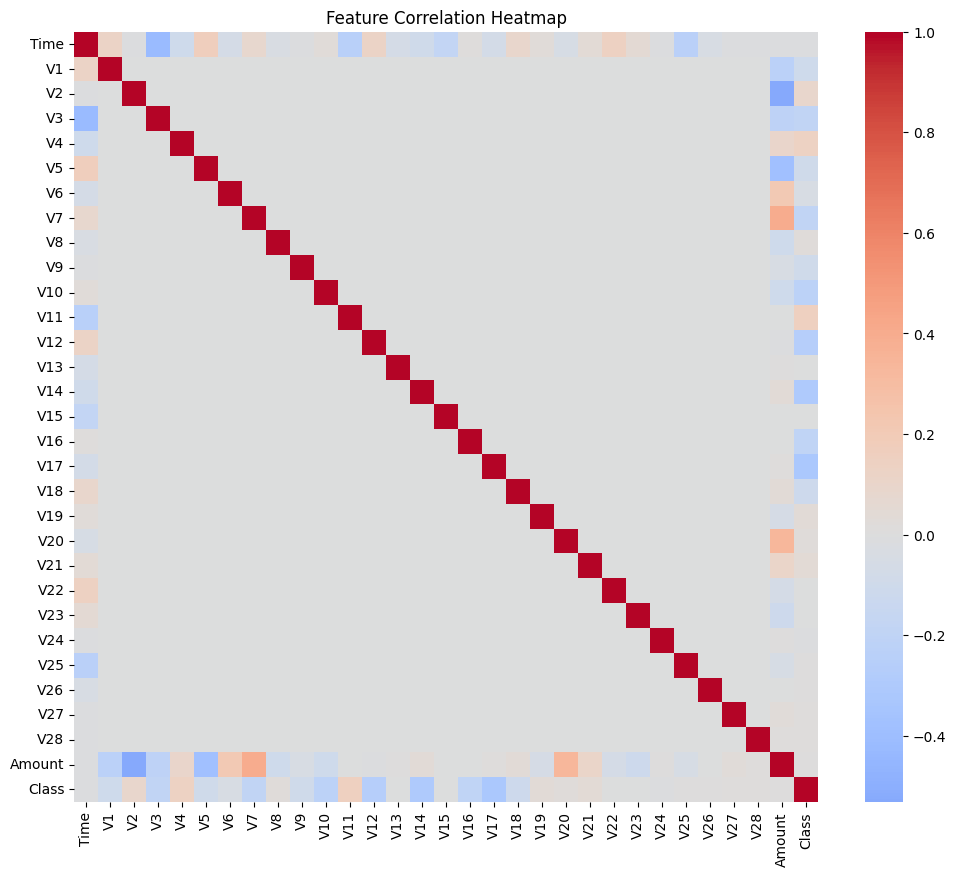

/tmp/ipykernel_29370/2390381838.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette="coolwarm")


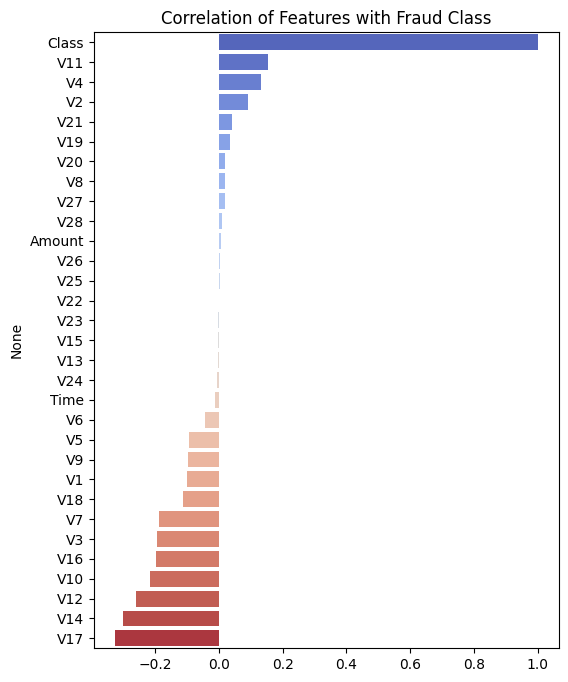

In [9]:
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0, cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

# correlations with Class only
plt.figure(figsize=(6,8))
corr_target = corr["Class"].sort_values(ascending=False)
sns.barplot(x=corr_target.values, y=corr_target.index, palette="coolwarm")
plt.title("Correlation of Features with Fraud Class")
plt.show()


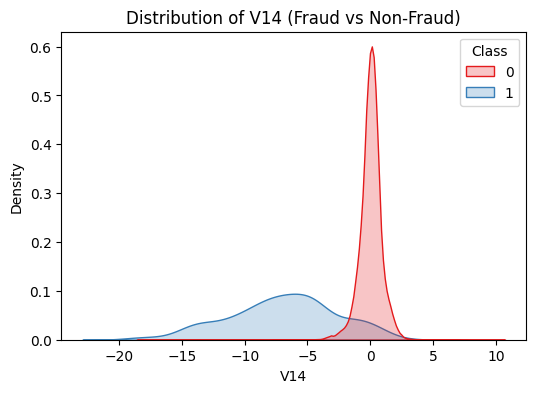

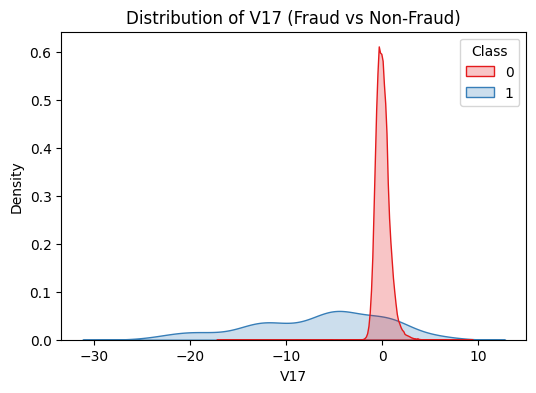

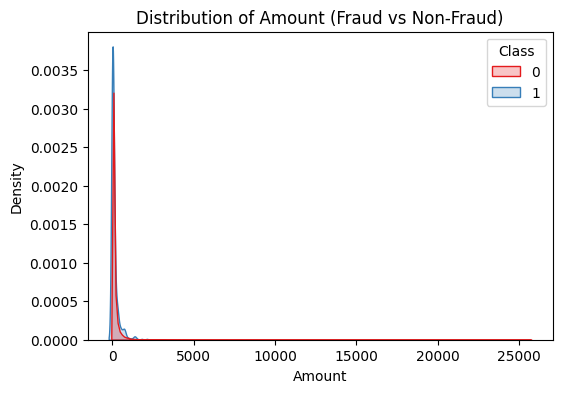

In [10]:
features_to_plot = ["V14", "V17", "Amount"]

for f in features_to_plot:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=df, x=f, hue="Class", fill=True, common_norm=False, palette="Set1")
    plt.title(f"Distribution of {f} (Fraud vs Non-Fraud)")
    plt.show()


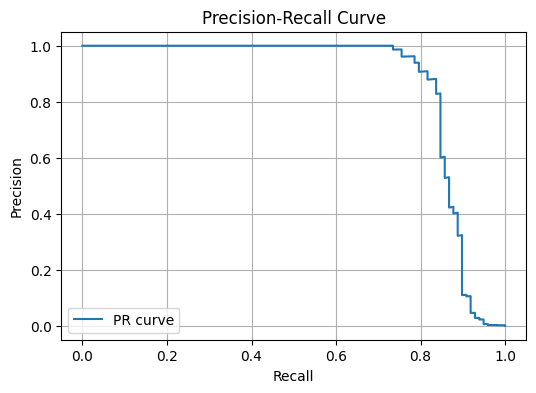

In [11]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Use XGBoost probs as example
probs = probs_xgb  # from eval_model()
precision, recall, thresholds = precision_recall_curve(y_test, probs)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label="PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


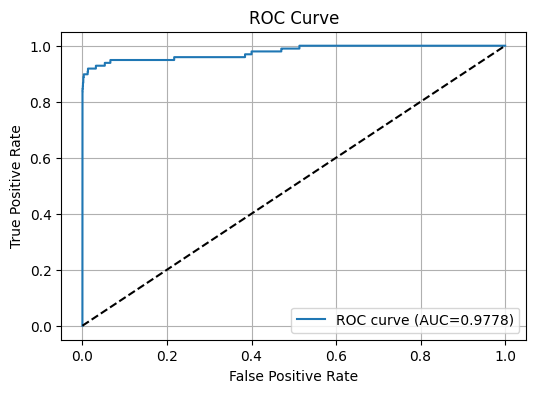

In [12]:
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.4f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


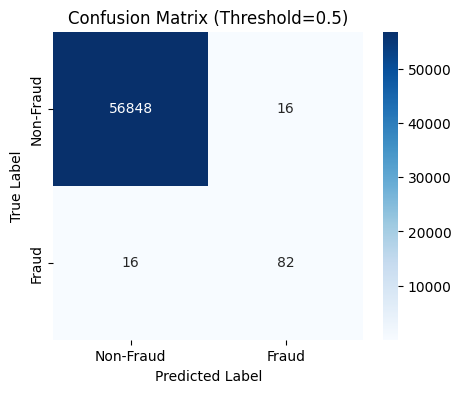

In [13]:
from sklearn.metrics import confusion_matrix

preds = (probs >= 0.5).astype(int)
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud","Fraud"], yticklabels=["Non-Fraud","Fraud"])
plt.title("Confusion Matrix (Threshold=0.5)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [1]:
#!/bin/bash
! curl -L -o creditcardfraud.zip\
  https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 65.9M  100 65.9M    0     0  3677k      0  0:00:18  0:00:18 --:--:-- 6839k


In [2]:
! unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          
